In [5]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
# from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint as odeint
from model import ODEBlock
import random

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = ("cpu")

In [7]:
# load the dataset
t = torch.load("./data/t.pth")
X = torch.load("./data/X.pth")

In [8]:
X.shape

torch.Size([471, 901, 38])

In [9]:
def getTrainingData():
    return t, X[range(0, 101, 50)]

In [10]:
def getTestData(FaultDuration=35):
    return t, X[FaultDuration - 30]

# Training

In [11]:
t_eval, X_train = getTrainingData()
X_train.shape

torch.Size([3, 901, 38])

In [12]:
# parameters
num_traj = X_train.shape[0]
data_size = X_train.shape[1]
batch_time = 10
batch_size = 256
dim = X_train.shape[-1]

In [13]:
def get_batch(dataset, t):
    Batch_y0 = torch.Tensor()
    Batch_y = torch.Tensor()
    for ii in range(num_traj):
        true_y = dataset[ii]
        s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=True))
        batch_y0 = true_y[s]  # (M, D)
        batch_t = t[:batch_time]  # (T)
        batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
        Batch_y0 = torch.cat((Batch_y0, batch_y0), dim=-2)
        Batch_y = torch.cat((Batch_y, batch_y), dim=-2)
    # return Batch_y0, batch_t, Batch_y
    return Batch_y0.to(device), batch_t.to(device), Batch_y.to(device)

In [14]:
batch_y0, batch_t, batch_y = get_batch(X_train, t_eval)

In [15]:
batch_y0.shape, batch_y.shape, batch_t.shape

(torch.Size([768, 38]), torch.Size([10, 768, 38]), torch.Size([10]))

In [16]:
model = ODEBlock(dim,1000,dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
ITRs = 1000

In [17]:
Loss_train = []
Loss_test = []
for i in range(ITRs):
    batch_y0, batch_t, batch_y = get_batch(X_train, t_eval)
    optimizer.zero_grad()
    batch_y_hat = odeint(model, batch_y0, batch_t, atol=1e-6)
    loss = criterion(batch_y_hat, batch_y)
    loss.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        Loss_train.append(loss.item())
        print(f'iteration: [{i+1}/{ITRs}], training loss: {loss.item():.6f}')


iteration: [10/1000], training loss: 0.001186
iteration: [20/1000], training loss: 0.000848
iteration: [30/1000], training loss: 0.000681
iteration: [40/1000], training loss: 0.000646
iteration: [50/1000], training loss: 0.000617
iteration: [60/1000], training loss: 0.000568
iteration: [70/1000], training loss: 0.000518
iteration: [80/1000], training loss: 0.000483
iteration: [90/1000], training loss: 0.000431
iteration: [100/1000], training loss: 0.000374
iteration: [110/1000], training loss: 0.000324
iteration: [120/1000], training loss: 0.000279
iteration: [130/1000], training loss: 0.000237
iteration: [140/1000], training loss: 0.000212
iteration: [150/1000], training loss: 0.000197
iteration: [160/1000], training loss: 0.000182
iteration: [170/1000], training loss: 0.000151
iteration: [180/1000], training loss: 0.000144
iteration: [190/1000], training loss: 0.000142
iteration: [200/1000], training loss: 0.000116
iteration: [210/1000], training loss: 0.000108
iteration: [220/1000],

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


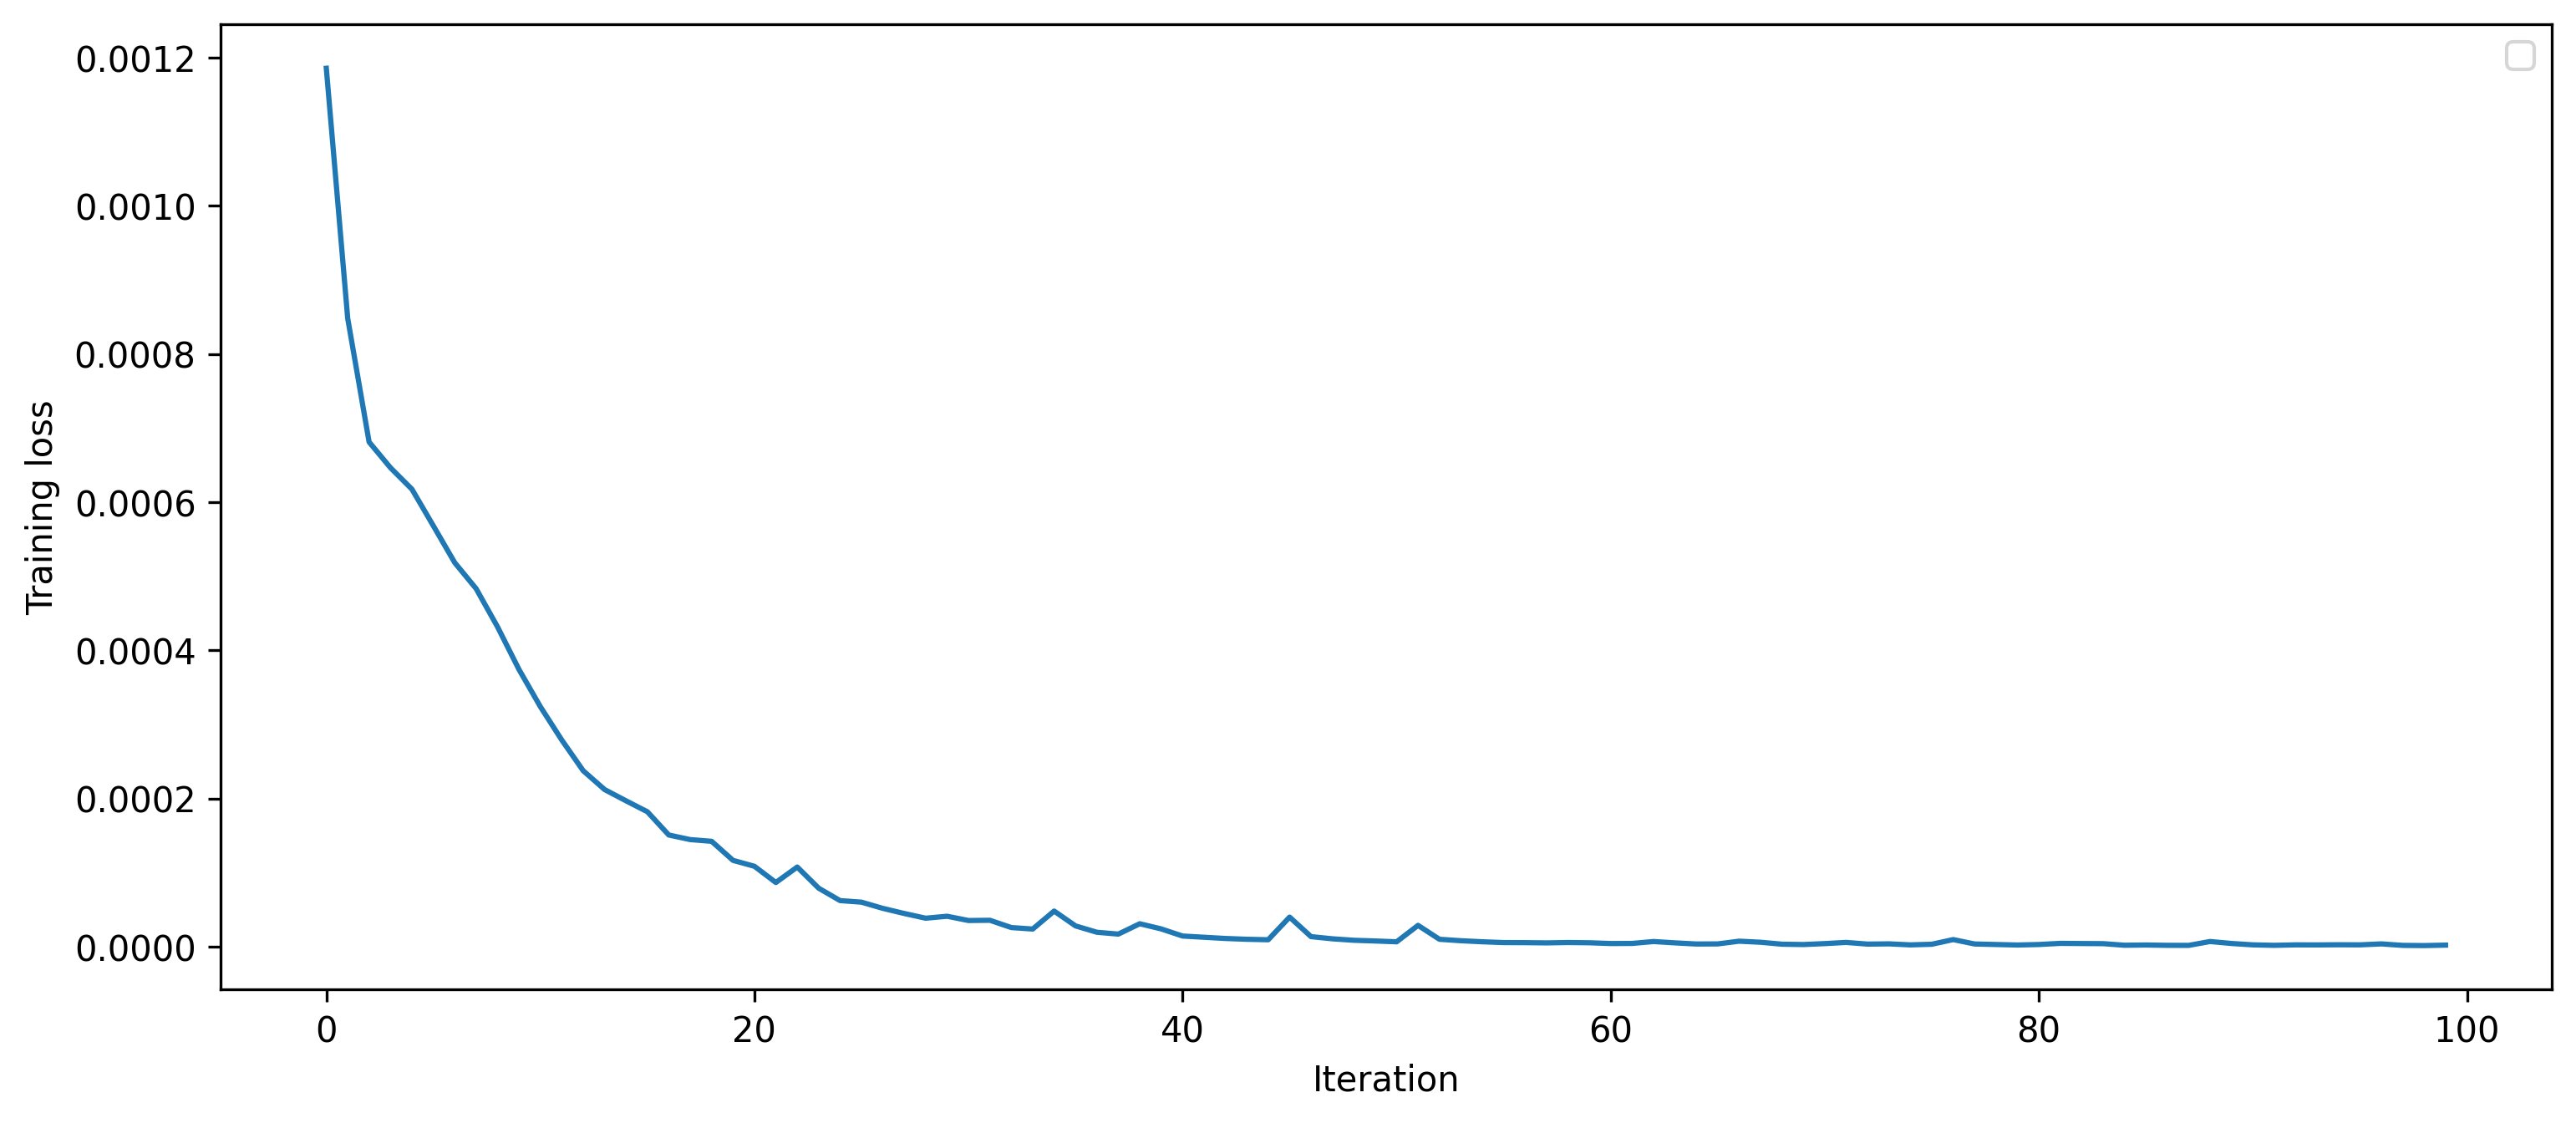

In [18]:
plt.figure(figsize=(12,5), dpi=300)
plt.plot(range(len(Loss_train)), Loss_train)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend()

In [28]:
torch.save(model.state_dict(), './result/model/ODEBlock_gen.pth')

# Evaluation

In [26]:
from scipy.integrate import solve_ivp
model.eval()
T = 6
FaultDuration=150
model.to("cpu")

t_eval, X_test = getTestData(FaultDuration=FaultDuration)
t_eval = t_eval - t_eval[0]
t_eval = t_eval[:T*100]
t_span = [t_eval[0],t_eval[-1]]
y0 = X_test[1,:]
y0

X_test_hat =odeint(model, y0, t_eval, method='dopri5').detach()

X_test = X_test[:T*100]

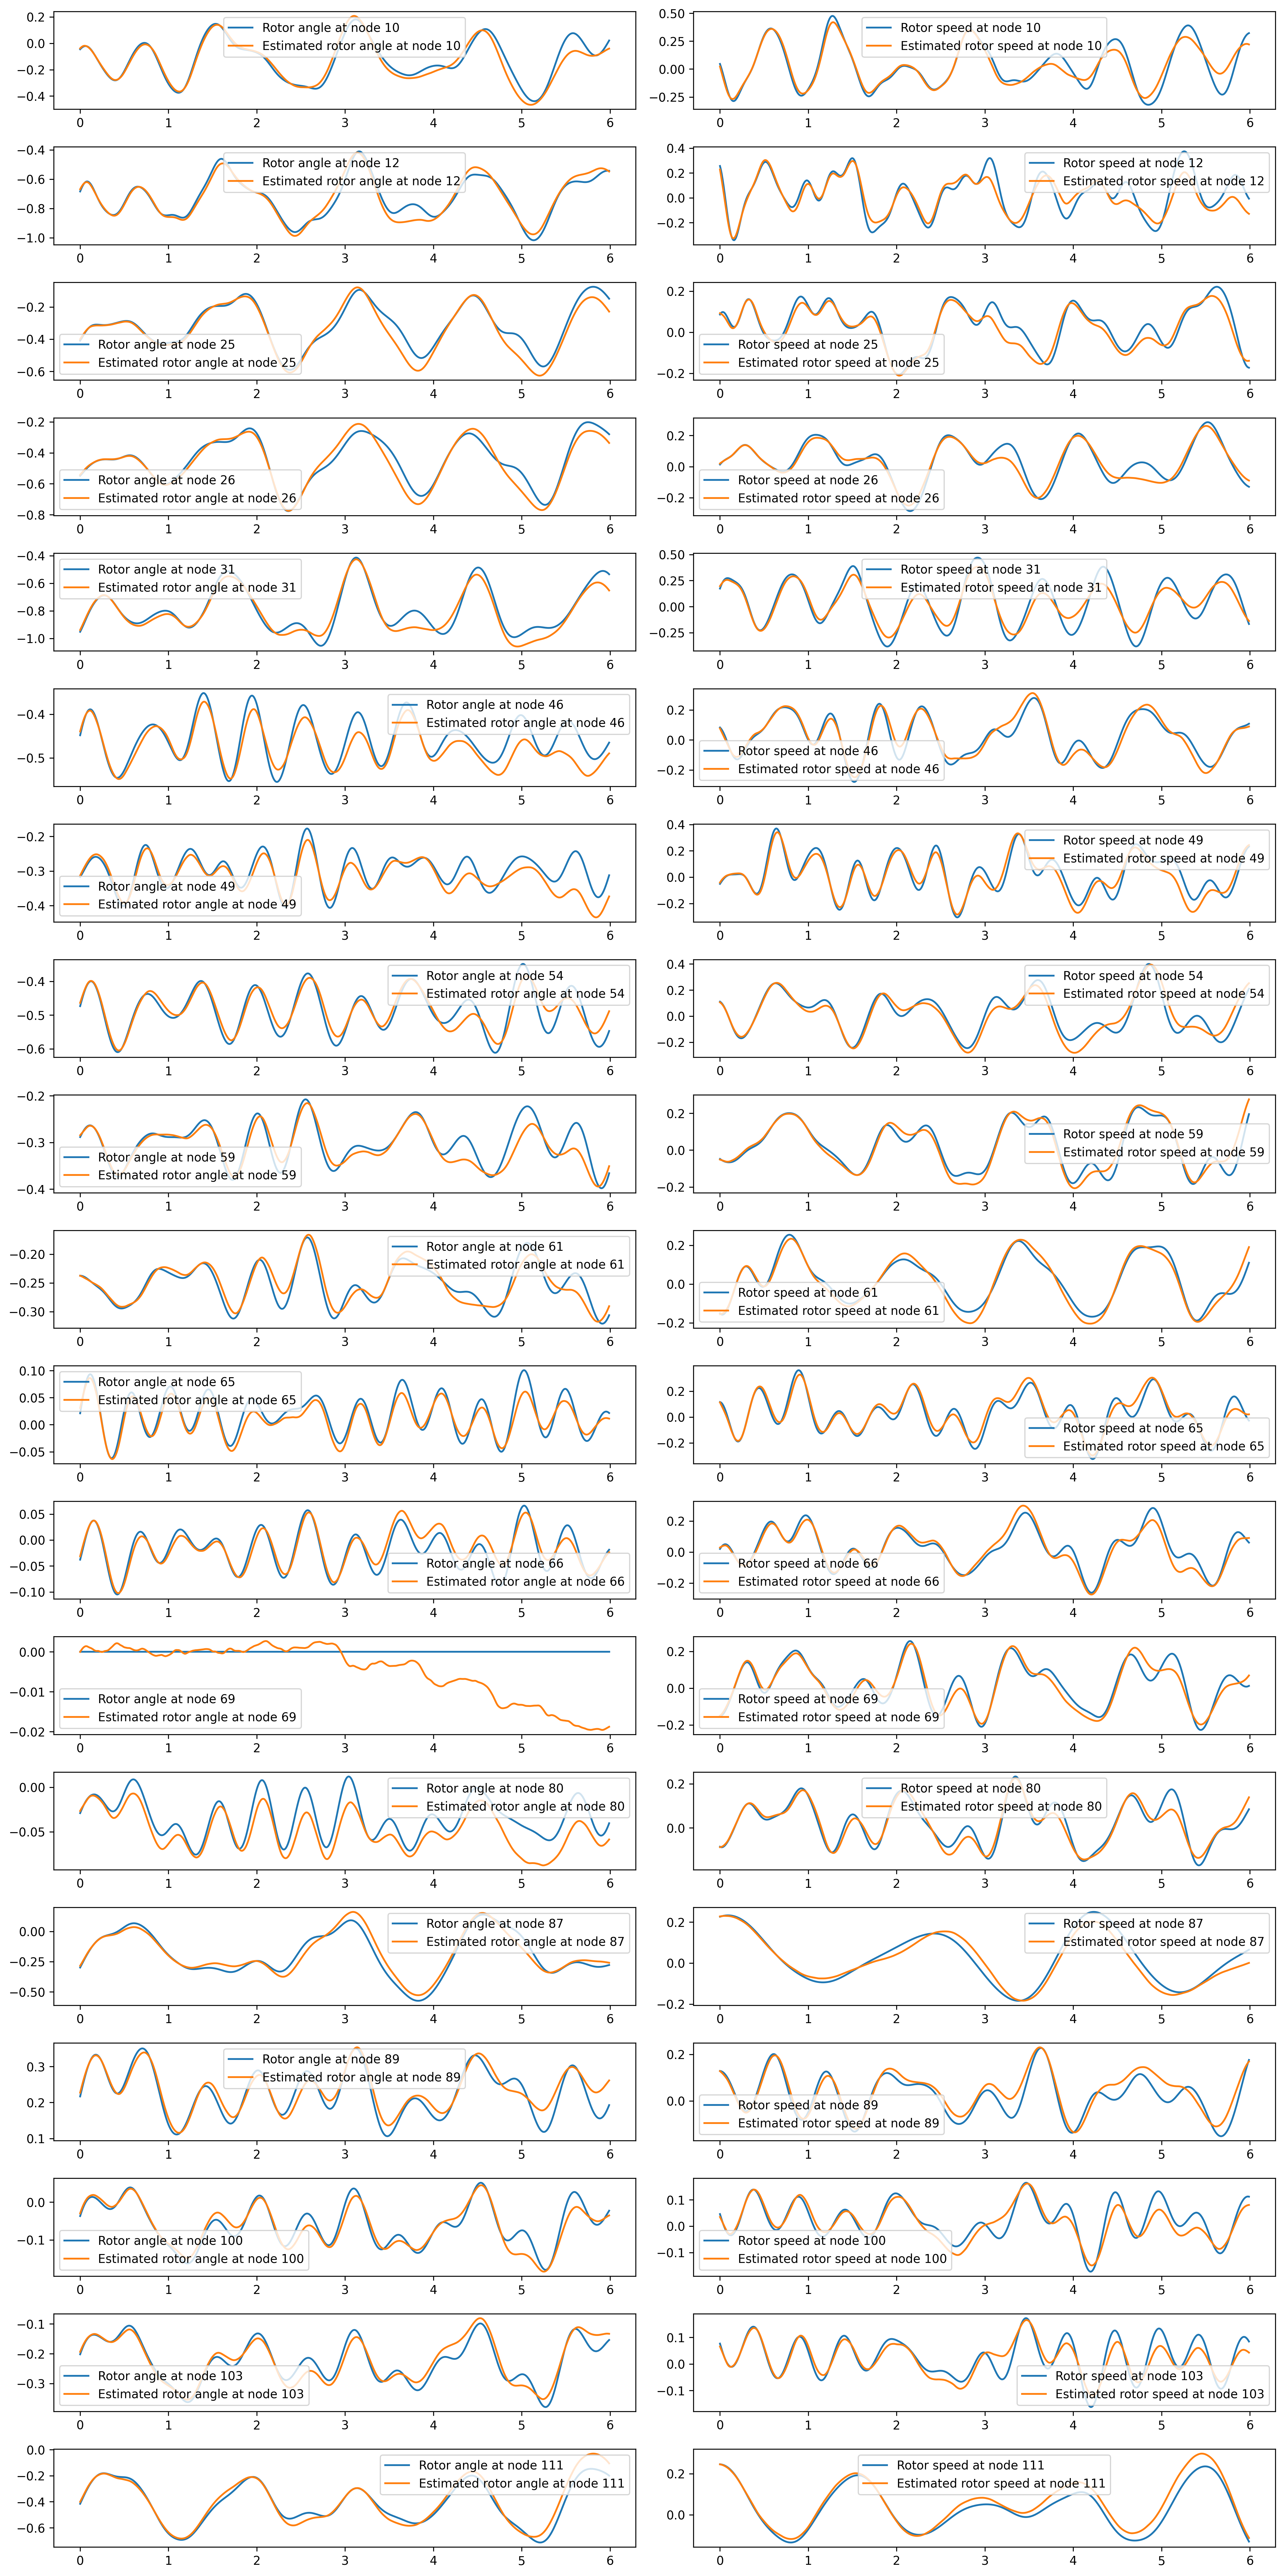

In [27]:
plt.figure(figsize=(15,30),dpi=300)
Generator_nodes = [10, 12, 25, 26, 31, 46, 49, 54, 59, 61, 65, 66, 69, 80, 87, 89, 100, 103, 111]
for i, node in enumerate(Generator_nodes):
    plt.subplot(19,2,2 * i + 1)
    plt.plot(t_eval, X_test[:,2 * i], label="Rotor angle at node {}".format(node))
    plt.plot(t_eval, X_test_hat[:,2 * i], label="Estimated rotor angle at node {}".format(node))
    plt.legend()
    plt.subplot(19,2,2 * i + 2)
    plt.plot(t_eval, X_test[:,2 * i + 1], label="Rotor speed at node {}".format(node))
    plt.plot(t_eval, X_test_hat[:,2 * i + 1], label="Estimated rotor speed at node {}".format(node))
    plt.legend()
plt.tight_layout()
plt.savefig("./result/test result/NeuralODE-FaultDuration{}".format(FaultDuration))